# American option pricing with Longstaff–Schwartz

This notebook implements from scratch the Longstaff–Schwartz least-squares Monte Carlo algorithm to price an American put option under a geometric Brownian motion (Black–Scholes dynamics).

We will:

1. Simulate paths of a geometric Brownian motion (GBM) for the underlying asset.
2. Define an American put payoff.
3. Implement the Longstaff–Schwartz algorithm to decide, on each path and at each exercise date, whether it is better to continue or exercise.
4. Compare the estimated American price to the corresponding European put price under the same dynamics.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 1. Model and simulation set-up

We consider a risk-neutral GBM for the underlying price \(S_t\):

\[
dS_t = r S_t \, dt + \sigma S_t \, dW_t,
\]

with

- risk-free rate \(r\),
- volatility \((\sigma\),
- initial price \(S_0\).

We simulate \(N_{\text{paths}}\) paths on a grid of \(N_{\text{steps}}\) dates between \(t=0\) and maturity \(T\).

In [2]:
# Model parameters
r = 0.02      # risk-free rate
sigma = 0.15  # volatility
S0 = 1.0      # initial price
T = 0.5       # maturity in years (6 months)
N_steps = 120 # time grid size
N_paths = 2_000  # number of Monte Carlo paths

dt = T / N_steps
times = np.linspace(0.0, T, N_steps + 1)

# Simulate GBM paths under risk-neutral measure using log-Euler scheme
# S_{t+dt} = S_t * exp((r - 0.5*sigma^2) dt + sigma * sqrt(dt) * Z)
Z = np.random.normal(size=(N_steps, N_paths))
drift = (r - 0.5 * sigma**2) * dt
diffusion = sigma * np.sqrt(dt)

S = np.empty((N_steps + 1, N_paths))
S[0, :] = S0

for t in range(1, N_steps + 1):
    S[t, :] = S[t-1, :] * np.exp(drift + diffusion * Z[t-1, :])

S.shape

(121, 2000)

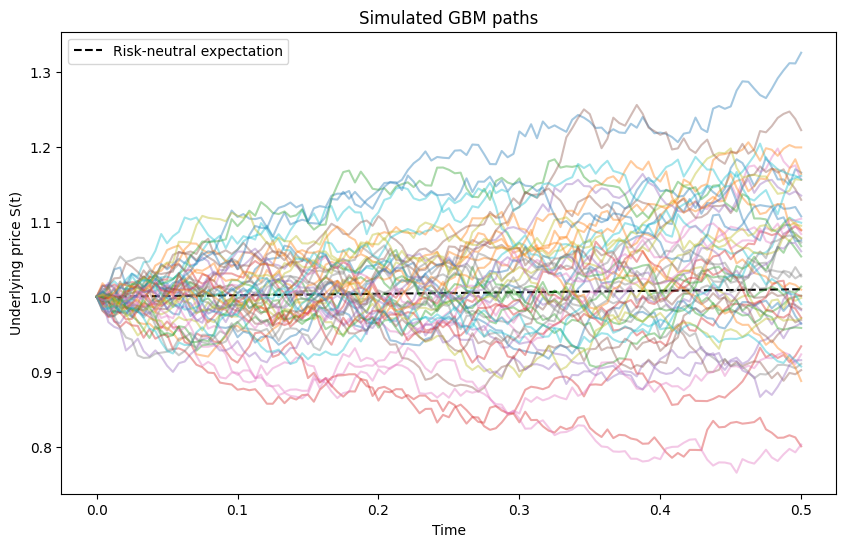

In [3]:
# Theoretical risk-neutral expectation: E[S_t] = S0 * exp(r * t)
expectation = S0 * np.exp(r * times)

plt.plot(times, expectation, 'k--', label='Risk-neutral expectation')
for i in range(50):  # plot only a subset for readability
    plt.plot(times, S[:, i], alpha=0.4)
plt.xlabel('Time')
plt.ylabel('Underlying price S(t)')
plt.title('Simulated GBM paths')
plt.legend()
plt.show()

## 2. American put payoff and in-the-money region

We consider an American (Bermudan on the grid) put option with strike \(K\).

At each exercise date \(t_i\) on our grid, the holder can exercise and receive

\[
Y(t_i) = (K - S_{t_i})^+.
\]

If the holder does not exercise, the option survives to the next step. The seller must therefore compare, at each date and on each path, the immediate exercise value to the continuation value.

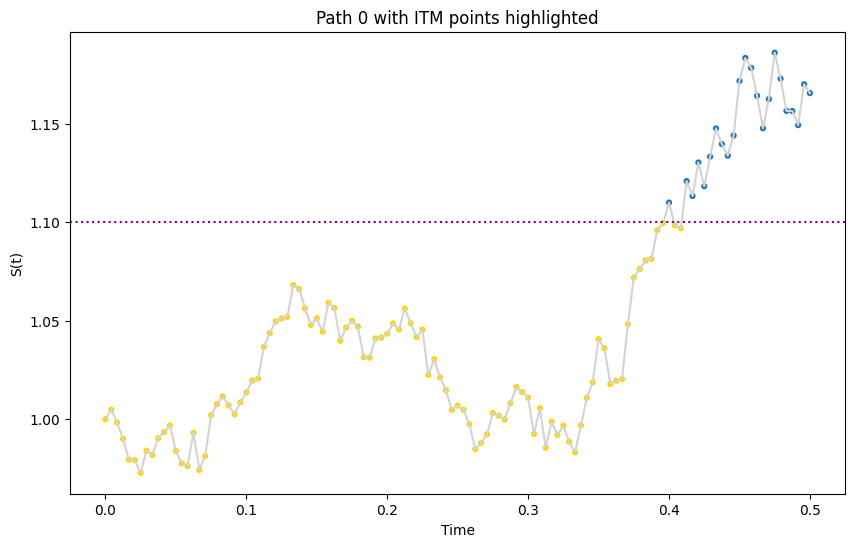

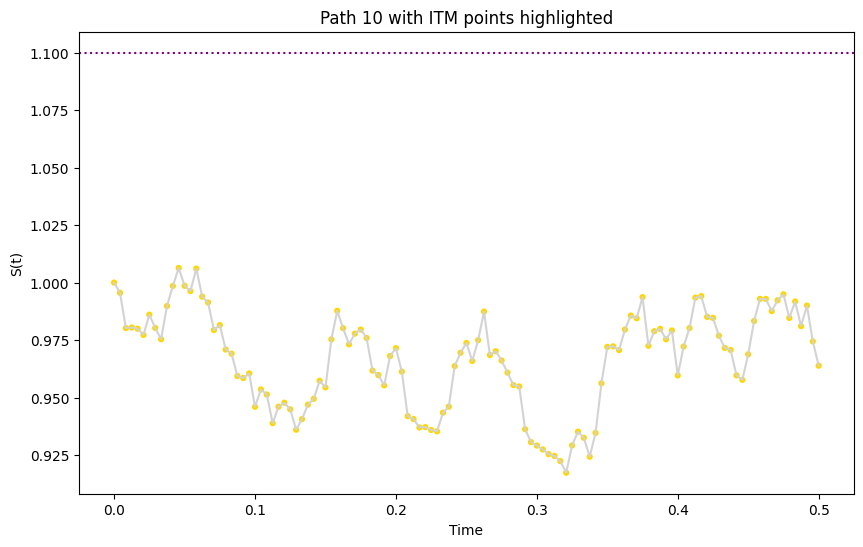

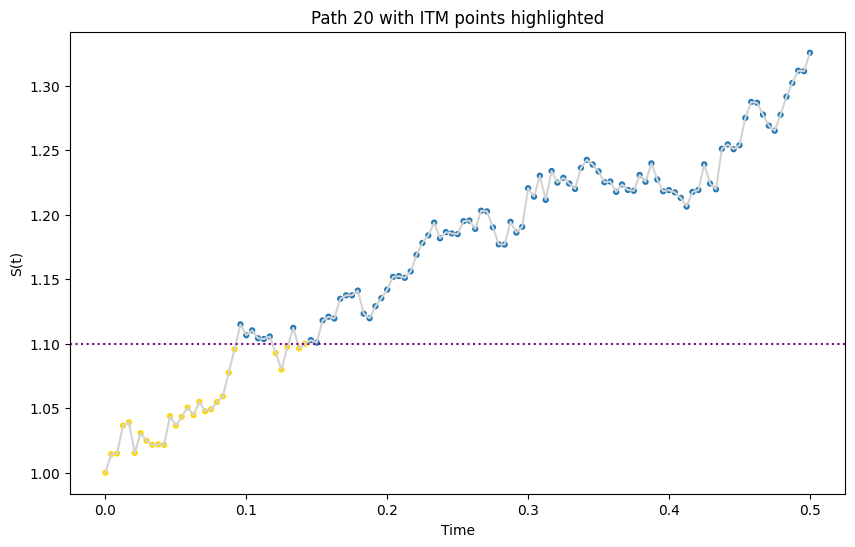

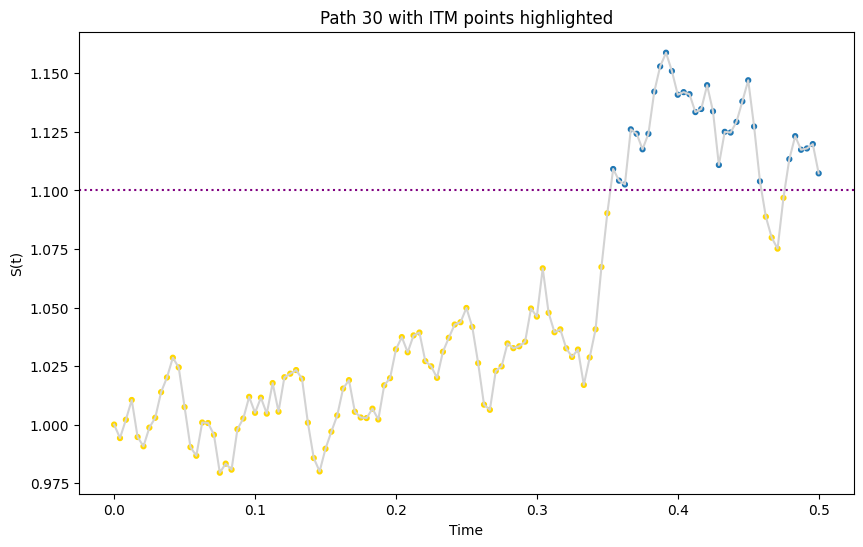

In [4]:
K = 1.1

def exercise_value(S):
    """American put payoff (K - S)^+ for a given price array S."""
    return np.maximum(K - S, 0.0)

# Plot a few paths and highlight in-the-money points
indices = [0, 10, 20, 30]

for idx in indices:
    path = S[:, idx]
    itm = path < K
    colors = np.where(itm, 'gold', 'tab:blue')
    plt.plot(times, path, color='lightgray')
    plt.scatter(times, path, c=colors, s=12)
    plt.axhline(y=K, linestyle=':', color='purple', label='Strike K')
    plt.title(f'Path {idx} with ITM points highlighted')
    plt.xlabel('Time')
    plt.ylabel('S(t)')
    plt.show()

## 3. Longstaff–Schwartz algorithm (least-squares Monte Carlo)

The key idea is:

1. Work **backwards in time** from maturity to today.
2. At maturity, the option value on each path is just the payoff \(Y(T)\).
3. At an earlier time \(t_i\), for each path:
   - We know the discounted future cashflow assuming we continue (coming from \(t_{i+1}\)).
   - On paths where the option is in the money, we regress this discounted cashflow on functions of the current underlying price \(S_{t_i}\) (e.g. polynomials) to estimate the **continuation value** \(C(t_i)\).
   - We compare exercise value \(Y(t_i)\) to continuation value \(C(t_i)\):
     - If \(Y(t_i) > C(t_i)\), it is optimal to exercise here on this path.
     - Otherwise, we continue and keep the discounted future cashflow.

At the end of the backward induction, the Monte Carlo estimate of the American option price is the discounted average of all realised cashflows over the paths.

In [5]:
def longstaff_schwartz_american_put(S_paths, K, r, dt, degree=3):
    """
    Longstaff–Schwartz least-squares Monte Carlo for an American put.
    
    Parameters
    ----------
    S_paths : ndarray, shape (N_steps+1, N_paths)
        Simulated underlying paths.
    K : float
        Strike of the put.
    r : float
        Risk-free rate.
    dt : float
        Time step.
    degree : int
        Degree of the polynomial basis in S used for regression.
    
    Returns
    -------
    price : float
        Estimated American put price at t=0.
    exercise_indicator : ndarray, shape (N_steps+1, N_paths)
        Boolean array indicating at which time and path exercise occurs.
    cashflows : ndarray, shape (N_paths,)
        Realised discounted cashflow per path (from the optimal policy).
    """
    N_steps, N_paths = S_paths.shape[0] - 1, S_paths.shape[1]
    
    # Terminal cashflows: exercise at maturity if ITM
    exercise_payoff_T = exercise_value(S_paths[-1, :])
    cashflows = exercise_payoff_T.copy()
    
    # Keep track of where exercise happens (for diagnostics/plots)
    exercise_indicator = np.zeros_like(S_paths, dtype=bool)
    exercise_indicator[-1, :] = cashflows > 0
    
    discount = np.exp(-r * dt)
    
    # Work backwards from the second last time step to the first
    for t_idx in range(N_steps - 1, 0, -1):
        S_t = S_paths[t_idx, :]
        exercise_now = exercise_value(S_t)
        
        # Discount existing cashflows back by one step
        cashflows *= discount
        
        # Consider only in-the-money paths for regression
        itm = exercise_now > 0
        if np.any(itm):
            # Basis: [1, S, S^2, ..., S^degree]
            X = np.vstack([S_t[itm]**d for d in range(degree + 1)]).T
            y = cashflows[itm]
            
            # Least-squares fit: beta = argmin ||X beta - y||^2
            beta, *_ = np.linalg.lstsq(X, y, rcond=None)
            
            # Estimated continuation value on all paths
            X_all = np.vstack([S_t**d for d in range(degree + 1)]).T
            continuation = X_all @ beta
        else:
            continuation = np.zeros_like(S_t)
        
        # Decide whether to exercise now
        exercise_decision = itm & (exercise_now > continuation)
        
        # For paths where we exercise now, overwrite cashflows
        cashflows[exercise_decision] = exercise_now[exercise_decision]
        
        # Mark exercise
        exercise_indicator[t_idx, exercise_decision] = True
    
    # Finally discount one more step back to t=0
    cashflows *= discount
    price = np.mean(cashflows)
    return price, exercise_indicator, cashflows

In [6]:
american_price, exercise_indicator, cashflows = longstaff_schwartz_american_put(
    S_paths=S,
    K=K,
    r=r,
    dt=dt,
    degree=3
)

european_payoff = exercise_value(S[-1, :])
european_price = np.exp(-r * T) * np.mean(european_payoff)

print(f"Estimated American put price (LSMC): {american_price:.6f}")
print(f"Estimated European put price (MC):  {european_price:.6f}")

Estimated American put price (LSMC): 0.104186
Estimated European put price (MC):  0.101728


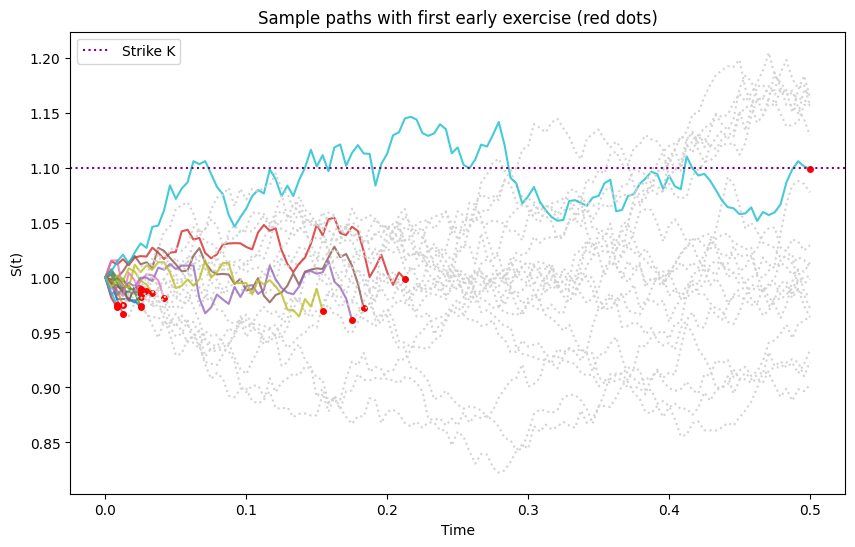

In [7]:
first_exercise_idx = np.argmax(exercise_indicator, axis=0)

n_show = 20
plt.figure(figsize=(10, 6))
for i in range(n_show):
    path = S[:, i]
    t_ex_idx = first_exercise_idx[i]
    if t_ex_idx == 0 and not exercise_indicator[0, i]:
        plt.plot(times, path, '-', alpha=0.5)
    else:
        plt.plot(times[:t_ex_idx+1], path[:t_ex_idx+1], '-', alpha=0.8)
        plt.plot(times[t_ex_idx:], path[t_ex_idx:], ':', color='lightgray')
        plt.plot(times[t_ex_idx], path[t_ex_idx], 'r.', markersize=8)

plt.axhline(y=K, linestyle=':', color='purple', label='Strike K')
plt.xlabel('Time')
plt.ylabel('S(t)')
plt.title('Sample paths with first early exercise (red dots)')
plt.legend()
plt.show()